In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, MaxPooling3D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten,  MaxPooling2D, Concatenate

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q -d 'All-Age_Faces' 'drive/MyDrive/All-Age-Faces Dataset.zip'

In [ ]:
!ls

All-Age_Faces  drive  sample_data


In [ ]:
!find All-Age_Faces '*.jpg'

In [ ]:
train_people_og = glob.glob('All-Age_Faces/All-Age-Faces Dataset/original images/*.jpg')
train_people_gd = glob.glob('All-Age_Faces/All-Age-Faces Dataset/aglined faces/*.jpg')
print(len(train_people_og))
print(len(train_people_gd))

13322
13322


In [ ]:
train_people_og = sorted(train_people_og)
train_people_gd = sorted(train_people_gd)

In [ ]:
test = []
for i in train_people_og[1000:1010]:
  now = i.split('.')[-2][-2:]
  print(now)
  test.append(now)
print(test)

17
17
17
17
17
17
17
17
17
17
['17', '17', '17', '17', '17', '17', '17', '17', '17', '17']


In [ ]:
train_labels = list()
for i in train_people_og:
    now = int(i.split('.')[-2][-2:])
    if now <= 7:
        train_labels.append('유아')
    elif now <= 13:
        train_labels.append('초등학생')
    elif now <= 19:
        train_labels.append('청소년')
    elif now <= 64:
        train_labels.append('성인')
    elif now <= 89:
        train_labels.append('노약자')

In [ ]:
train_people_gd[:10]

['All-Age_Faces/All-Age-Faces Dataset/aglined faces/00000A02.jpg',
 'All-Age_Faces/All-Age-Faces Dataset/aglined faces/00001A02.jpg',
 'All-Age_Faces/All-Age-Faces Dataset/aglined faces/00002A02.jpg',
 'All-Age_Faces/All-Age-Faces Dataset/aglined faces/00003A02.jpg',
 'All-Age_Faces/All-Age-Faces Dataset/aglined faces/00004A02.jpg',
 'All-Age_Faces/All-Age-Faces Dataset/aglined faces/00005A02.jpg',
 'All-Age_Faces/All-Age-Faces Dataset/aglined faces/00006A02.jpg',
 'All-Age_Faces/All-Age-Faces Dataset/aglined faces/00007A02.jpg',
 'All-Age_Faces/All-Age-Faces Dataset/aglined faces/00008A02.jpg',
 'All-Age_Faces/All-Age-Faces Dataset/aglined faces/00009A02.jpg']

In [ ]:
test_labels = list()
for i in train_people_gd:
    now = int(i.split('.')[-2][-2:])
    if now <= 7:
        test_labels.append('유아')
    elif now <= 13:
        test_labels.append('초등학생')
    elif now <= 19:
        test_labels.append('청소년')
    elif now <= 64:
        test_labels.append('성인')
    elif now <= 89:
        test_labels.append('노약자')


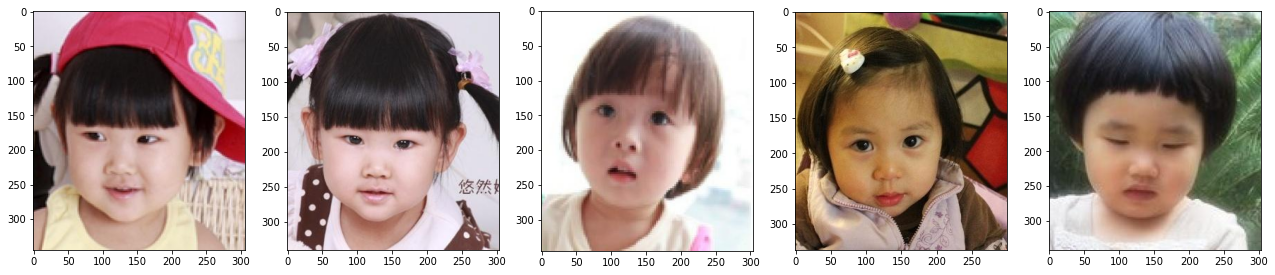

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=5, figsize=(22, 6))
people = train_people_og[:5]
for i in range(5):
    axes[i].imshow(cv2.cvtColor(cv2.imread(people[i]), cv2.COLOR_BGR2RGB))

In [ ]:
train_path = train_people_og

train_df = pd.DataFrame({'path' : train_path, 'label' : train_labels})

In [ ]:
test_path = train_people_gd

test_df = pd.DataFrame({'path' : test_path, 'label' : test_labels})

In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])
#type(train_df.label[0])

In [ ]:
test_df.label.value_counts()

성인      10191
노약자       847
유아        786
청소년       769
초등학생      729
Name: label, dtype: int64

유아
유아
유아
유아
유아


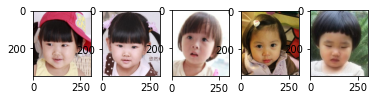

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5)

for i in range(5):
  axes[i].imshow(cv2.cvtColor(cv2.imread(train_df.path[i]), cv2.COLOR_BGR2RGB))
  print(train_df.label[i])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10657 entries, 11379 to 12728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    10657 non-null  object
 1   label   10657 non-null  object
dtypes: object(2)
memory usage: 569.8+ KB


In [ ]:
len(train_df.label)

10657

In [ ]:
len(train_df.path)

10657

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
train_generator = ImageDataGenerator(rescale = 1/255.0, 
                                   rotation_range=60, # 40 + 60 
                                   width_shift_range=0.2, 
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = False,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')
train_generator_iterator = train_generator.flow_from_dataframe(dataframe=train_df,
                                                               x_col = "path",
                                                               y_col = "label",
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 10657 validated image filenames belonging to 5 classes.


In [ ]:
valid_generator = ImageDataGenerator(rescale=1/255.0)
valid_generator_iterator = valid_generator.flow_from_dataframe(dataframe=valid_df, x_col='path', y_col='label', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)  

Found 2665 validated image filenames belonging to 5 classes.


In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.0)
test_generator_iterator = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)  

Found 13322 validated image filenames belonging to 5 classes.


# vgg 모델

In [7]:
model = tf.keras.models.load_model('my_VGG16_model.h5')

TypeError: ('Keyword argument not understood:', 'keepdims')

# 구글넷 학습

In [ ]:
model.evaluate(test_generator_iterator)

417/417 [==============================] - 142s 263ms/step - loss: 1.1662 - accuracy: 0.7650


[1.166158676147461, 0.7649752497673035]

In [ ]:
pred = model.predict(test_generator_iterator)

In [ ]:
pred[0]

# 디텍터

In [ ]:
label = ['유아', '초등학생', '청소년', '성인', '노약자']
#img = cv2.imread('All-Age_Faces/All-Age-Faces Dataset/original images/00001A02.jpg')
def preprocessing(img):
  dst = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
  dst = dst.reshape(1, 224, 224, 3)
  dst = np.array(dst / 225.0, dtype=np.float64)
  now = model.predict(dst)
  pred = label[now.argmax()]
  return pred

In [ ]:
def preprocess_gen(img):
  test1 = ImageDataGenerator(rescale=1/255.0)
  test1_iter = test_generator.flow(img.reshape(1, img.shape[0], img.shape[1], img.shape[2]), batch_size=1)
  now = model.predict(test1_iter)
  pred = label[now.argmax()]
  return pred

In [8]:
import cv2

# haarcascade 불러오기
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

AttributeError: module 'cv2' has no attribute 'data'

In [ ]:
# 이미지 불러오기
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
label = ['유아', '초등학생', '청소년', '성인', '노약자']
# 얼굴 찾기
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    image = img[y:y+h, x:x+w,:]
    image = np.reshape
    now = model.predict(dst)
    print(label[now.argmax()])
    
    # 눈 찾기
    # roi_color = img[y:y + h, x:x + w]
    # roi_gray = gray[y:y + h, x:x + w]
    # eyes = eye_cascade.detectMultiScale(roi_gray)
    # for (ex, ey, ew, eh) in eyes:
    #     cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

# 영상 출력



#key = cv2.waitKey(0)
#cv2.destroyAllWindows()

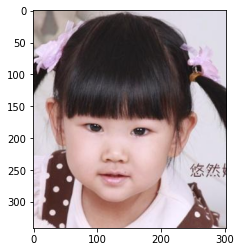

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
now

array([[0.21008001, 0.64626086, 0.02104232, 0.07004741, 0.05256935]],
      dtype=float32)

In [ ]:
cap = cv2.VideoCapture('http://172.30.1.41:4747/videofeed')

frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print(frame_size)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    retval, frame = cap.read() #프레임 캡쳐
    if not retval:
        break
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
      cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
      image = img[y:y+h, x:x+w,:]
      pred = preprocessing(image)
      cv2.putText(frame, pred (x, y+h), (255, 0, 0), 2)    
      cv2.imshow('frame', frame)
      break
    
    key = cv2.waitKey(25)
    if key == 27: #ESC
        break
if cap.isOpened(): #혹시나 처음부터 오류가 났을때 release를 못하니까.
    cap.release()
    
cv2.destroyAllWindows()

(0, 0)


In [ ]:
preprocessing(img)

'초등학생'

# 모델

In [ ]:
import tensorflow as tf
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.layers import batch_norm, flatten
from tensorflow.contrib.framework import arg_scope
from cifar10 import *
import numpy as np

weight_decay = 0.0005
momentum = 0.9

init_learning_rate = 0.1

reduction_ratio = 4

batch_size = 128
iteration = 391
# 128 * 391 ~ 50,000

test_iteration = 10

total_epochs = 100

In [ ]:


train_x, train_y, test_x, test_y = prepare_data()
train_x, test_x = color_preprocessing(train_x, test_x)


# image_size = 32, img_channels = 3, class_num = 10 in cifar10
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, img_channels])
label = tf.placeholder(tf.float32, shape=[None, class_num])

training_flag = tf.placeholder(tf.bool)


learning_rate = tf.placeholder(tf.float32, name='learning_rate')

logits = SE_Inception_resnet_v2(x, training=training_flag).model
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=logits))

l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum, use_nesterov=True)
train = optimizer.minimize(cost + l2_loss * weight_decay)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver(tf.global_variables())

with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('./model')
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())

    summary_writer = tf.summary.FileWriter('./logs', sess.graph)

    epoch_learning_rate = init_learning_rate
    for epoch in range(1, total_epochs + 1):
        if epoch % 30 == 0 :
            epoch_learning_rate = epoch_learning_rate / 10

        pre_index = 0
        train_acc = 0.0
        train_loss = 0.0

        for step in range(1, iteration + 1):
            if pre_index + batch_size < 50000:
                batch_x = train_x[pre_index: pre_index + batch_size]
                batch_y = train_y[pre_index: pre_index + batch_size]
            else:
                batch_x = train_x[pre_index:]
                batch_y = train_y[pre_index:]

            batch_x = data_augmentation(batch_x)

            train_feed_dict = {
                x: batch_x,
                label: batch_y,
                learning_rate: epoch_learning_rate,
                training_flag: True
            }

            _, batch_loss = sess.run([train, cost], feed_dict=train_feed_dict)
            batch_acc = accuracy.eval(feed_dict=train_feed_dict)

            train_loss += batch_loss
            train_acc += batch_acc
            pre_index += batch_size


        train_loss /= iteration # average loss
        train_acc /= iteration # average accuracy

        train_summary = tf.Summary(value=[tf.Summary.Value(tag='train_loss', simple_value=train_loss),
                                          tf.Summary.Value(tag='train_accuracy', simple_value=train_acc)])

        test_acc, test_loss, test_summary = Evaluate(sess)

        summary_writer.add_summary(summary=train_summary, global_step=epoch)
        summary_writer.add_summary(summary=test_summary, global_step=epoch)
        summary_writer.flush()

        line = "epoch: %d/%d, train_loss: %.4f, train_acc: %.4f, test_loss: %.4f, test_acc: %.4f \n" % (
            epoch, total_epochs, train_loss, train_acc, test_loss, test_acc)
        print(line)

        with open('logs.txt', 'a') as f:
            f.write(line)

        saver.save(sess=sess, save_path='./model/Inception_resnet_v2.ckpt')